In [23]:
# for basic SMILES operations, descriptors and fingerprints
!pip install -q rdkit-pypi

# for graphs
!pip install -q dgl

# for mol2vec
!pip install -q mol2vec

!pip install duckdb

!pip install faiss-gpu

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid de

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 12.6 MB/s eta 0:00:0000:01m00:01


In [2]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 57.8 MB/s eta 0:00:00:00:0100:01


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for basic SMILES operations, descriptors and fingerprints
from rdkit import Chem
from rdkit.Chem import Descriptors, MACCSkeys, AllChem
from rdkit.ML.Descriptors import MoleculeDescriptors

# for graphs
import dgl
import torch

# for mol2vec
from gensim.models import word2vec
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec

# for chemical language models
from transformers import AutoModel, AutoTokenizer

In [7]:
# load sample of training data for demo
df = pd.read_csv('/kaggle/input/leash-BELKA/train.csv', nrows=1000)
df.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
0,0,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,BRD4,0
1,1,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,HSA,0
2,2,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,sEH,0
3,3,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.NCc1cccc(Br)n1,C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...,BRD4,0
4,4,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.NCc1cccc(Br)n1,C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...,HSA,0


In [8]:
# assign unique molecule_smiles values to variable. This is all we need for the purpose of this demo
smiles = df['molecule_smiles'].unique()
print(len(smiles))

334


SMILES can be converted into standardized data structures called Mol objects which provide rich representations of molecular structures. Many of the embedding generation featured in this notebook relies on Mol objects as input.

Mol objects are generated using the RDKit package, a widely used cheminformatics library for molecular modeling, chemical analysis and computational chemistry.

In [9]:
# obtain RDKit mol objects from SMILES
mols = pd.Series(smiles).apply(Chem.MolFromSmiles)

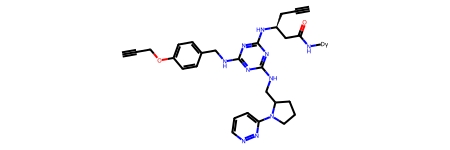

In [10]:
# mol objects can be readily viewed as 2d molecular drawings like so
mols[0]

In [13]:
# load pre-trained ChemBERTa model checkpoint and tokenizer
cb_tokenizer = AutoTokenizer.from_pretrained('DeepChem/ChemBERTa-10M-MLM')
cb_model = AutoModel.from_pretrained('DeepChem/ChemBERTa-10M-MLM')
cb_model.eval()

# tokenize SMILES
cb_encoded_inputs = cb_tokenizer(list(smiles), padding=True, truncation=True, return_tensors="pt")

# calculate embeddings
with torch.no_grad():
    outputs = cb_model(**cb_encoded_inputs)

# extract pooled output
cb_embeddings = outputs.pooler_output

cb_embeddings_df = pd.DataFrame(cb_embeddings.numpy())
cb_embeddings_df.head()

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-10M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,-0.563469,0.074372,0.487124,0.294959,0.339142,-0.182582,0.301397,-0.129053,-0.375246,-0.105981,...,-0.303291,-0.222114,0.389648,-0.242408,-0.075555,-0.061888,-0.185107,0.113040,0.144751,0.108391
1,-0.477216,0.017545,0.516992,0.176881,0.353979,-0.015709,0.272814,-0.041813,-0.413540,-0.061948,...,-0.298300,-0.188869,0.300606,-0.262610,-0.017158,-0.040419,-0.275134,0.109699,0.189485,0.286310
2,-0.546678,-0.017659,0.534062,0.312992,0.269971,-0.173409,0.298245,-0.069894,-0.383902,0.022807,...,-0.328160,-0.218355,0.297189,-0.249305,-0.065684,-0.117503,-0.243024,0.126069,0.221868,0.153962
3,-0.673190,-0.019038,0.557028,0.055006,0.306327,-0.126905,0.293456,-0.118870,-0.386376,0.030444,...,-0.358523,-0.227381,0.403943,-0.203773,-0.157019,-0.086750,-0.222699,0.196748,0.184002,0.223384
4,-0.641469,-0.013519,0.571010,0.102261,0.220781,-0.055523,0.329530,-0.085499,-0.399931,0.020052,...,-0.366031,-0.183668,0.347811,-0.209251,-0.090811,-0.127240,-0.218411,0.057709,0.187964,0.270494


In [14]:
# load pre-trained MolFormer model checkpoint and tokenizer
mf_tokenizer = AutoTokenizer.from_pretrained('ibm/MoLFormer-XL-both-10pct', deterministic_eval=True, trust_remote_code=True)
mf_model = AutoModel.from_pretrained('ibm/MoLFormer-XL-both-10pct', trust_remote_code=True)

# tokenize SMILES
mf_encoded_inputs = mf_tokenizer(list(smiles), padding=True, return_tensors="pt")

# calculate embeddings
with torch.no_grad():
    outputs = mf_model(**mf_encoded_inputs)

# extract embeddings
mf_embeddings = outputs.pooler_output

mf_embeddings_df = pd.DataFrame(mf_embeddings.numpy())
mf_embeddings_df.head()

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenization_molformer_fast.py:   0%|          | 0.00/6.50k [00:00<?, ?B/s]

tokenization_molformer.py:   0%|          | 0.00/9.48k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer_fast.py
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json:   0%|          | 0.00/41.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/54.0k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

configuration_molformer.py:   0%|          | 0.00/7.60k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- configuration_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_molformer.py:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- modeling_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/187M [00:00<?, ?B/s]

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.259716,-0.050058,0.181353,0.514790,-0.257365,-0.056821,0.637858,0.056062,0.260401,-0.038951,...,-0.316902,-0.610147,0.028590,-0.050373,0.431282,-0.344082,-3.331317,0.048564,-0.363147,-0.342910
1,-0.041573,-0.064774,0.490051,0.501262,0.021201,0.242967,0.713674,-0.120511,0.037418,-0.154792,...,-0.352241,-0.942419,-0.148811,-0.354638,0.492955,-0.358193,-3.144997,-0.071052,-0.541567,-0.300798
2,0.195743,-0.220446,0.808201,0.465860,-0.158075,0.094959,0.777796,-0.089055,-0.012065,-0.136461,...,-0.403105,-0.599708,-0.112346,-0.185206,0.342891,-0.088300,-3.231881,-0.196371,-0.402766,-0.563143
3,-0.177417,-0.285691,0.709522,0.428999,-0.302753,-0.094194,0.406966,0.023471,0.021343,-0.002636,...,-0.215111,-0.683172,-0.110922,-0.207361,0.406814,-0.059922,-2.915777,-0.196361,-0.570770,-0.148379
4,-0.080149,-0.256515,0.771587,0.523290,-0.215499,0.005914,0.670076,0.018636,-0.168800,0.021982,...,-0.020052,-0.814378,-0.202059,-0.349811,0.397703,-0.123963,-2.866192,-0.126020,-0.599488,-0.297162


### Inference

SVM Metrics: ROC AUC: 0.5, Accuracy: 0.995, F1 Score: 0.49874686716791977
Random Forest Metrics: ROC AUC: 1.0, Accuracy: 0.995, F1 Score: 0.49874686716791977
XGBoost Metrics: ROC AUC: 1.0, Accuracy: 0.995, F1 Score: 0.49874686716791977
Ensemble Metrics: ROC AUC: 1.0, Accuracy: 0.995, F1 Score: 0.49874686716791977


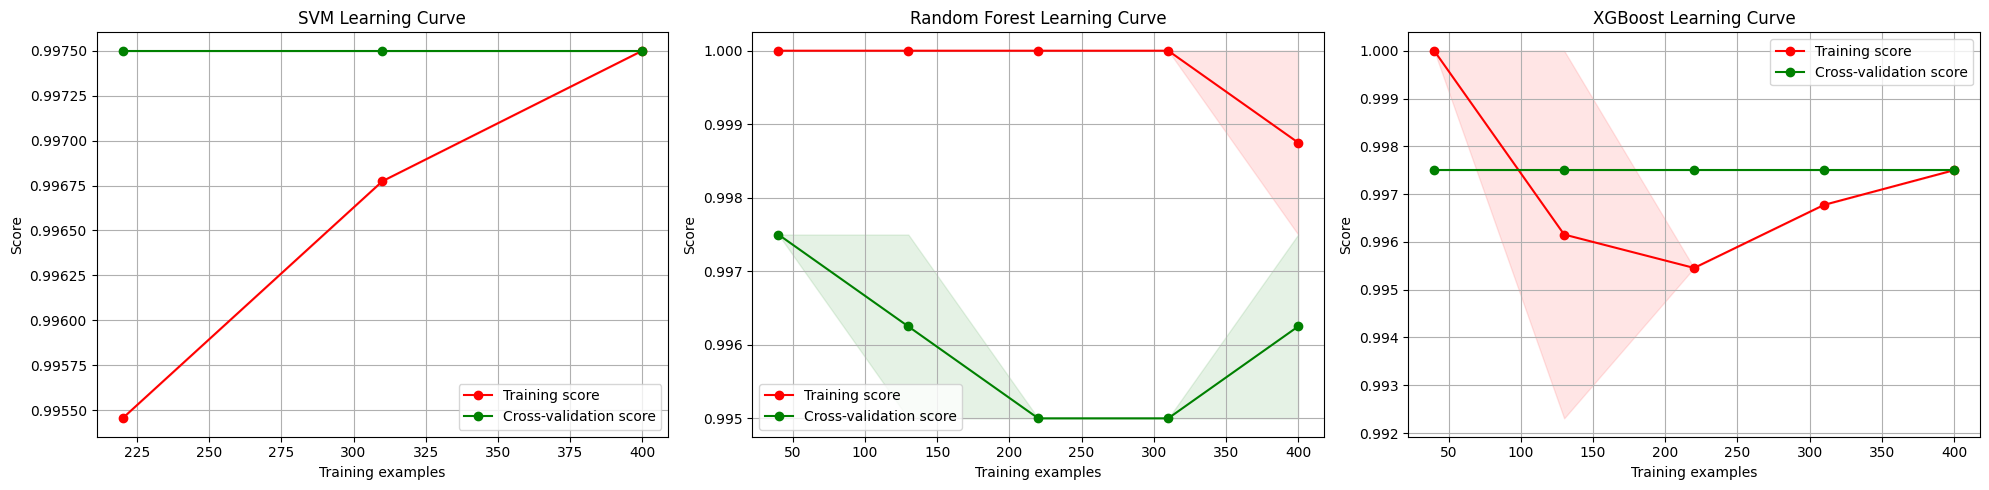

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from xgboost import XGBClassifier
import torch
from transformers import AutoModel, AutoTokenizer

# Load sample of training data for demo
df = pd.read_csv('/kaggle/input/leash-BELKA/train.csv', nrows=1000)
smiles = df['molecule_smiles']
labels = df['binds']

# Load pre-trained MolFormer model checkpoint and tokenizer
mf_tokenizer = AutoTokenizer.from_pretrained('ibm/MoLFormer-XL-both-10pct', deterministic_eval=True, trust_remote_code=True)
mf_model = AutoModel.from_pretrained('ibm/MoLFormer-XL-both-10pct', trust_remote_code=True)

# Tokenize SMILES
mf_encoded_inputs = mf_tokenizer(list(smiles), padding=True, return_tensors="pt")

# Calculate embeddings
with torch.no_grad():
    outputs = mf_model(**mf_encoded_inputs)

# Extract embeddings
mf_embeddings = outputs.pooler_output

mf_embeddings_df = pd.DataFrame(mf_embeddings.numpy())

# Train-test split
train_idx, val_idx = train_test_split(np.arange(len(df)), test_size=0.2, stratify=labels)
train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]

# Extract features and labels
train_features = mf_embeddings_df.iloc[train_idx].values
val_features = mf_embeddings_df.iloc[val_idx].values
train_labels = train_df['binds'].values
val_labels = val_df['binds'].values

# Training different models
svm_model = SVC(probability=True)
rf_model = RandomForestClassifier()
xgb_model = XGBClassifier()

svm_model.fit(train_features, train_labels)
rf_model.fit(train_features, train_labels)
xgb_model.fit(train_features, train_labels)

# Evaluate models
def evaluate_model(model, features, labels):
    predictions = model.predict(features)
    prob_predictions = model.predict_proba(features)[:, 1]
    roc_auc = roc_auc_score(labels, prob_predictions)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    return roc_auc, accuracy, f1

svm_metrics = evaluate_model(svm_model, val_features, val_labels)
rf_metrics = evaluate_model(rf_model, val_features, val_labels)
xgb_metrics = evaluate_model(xgb_model, val_features, val_labels)

print(f"SVM Metrics: ROC AUC: {svm_metrics[0]}, Accuracy: {svm_metrics[1]}, F1 Score: {svm_metrics[2]}")
print(f"Random Forest Metrics: ROC AUC: {rf_metrics[0]}, Accuracy: {rf_metrics[1]}, F1 Score: {rf_metrics[2]}")
print(f"XGBoost Metrics: ROC AUC: {xgb_metrics[0]}, Accuracy: {xgb_metrics[1]}, F1 Score: {xgb_metrics[2]}")

# Ensemble model
ensemble_model = VotingClassifier(estimators=[
    ('svm', svm_model), ('rf', rf_model), ('xgb', xgb_model)
], voting='soft')

ensemble_model.fit(train_features, train_labels)
ensemble_metrics = evaluate_model(ensemble_model, val_features, val_labels)

print(f"Ensemble Metrics: ROC AUC: {ensemble_metrics[0]}, Accuracy: {ensemble_metrics[1]}, F1 Score: {ensemble_metrics[2]}")

# Learning curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), ax=None):
    if ax is None:
        ax = plt.gca()
    
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax.grid()

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
            label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
            label="Cross-validation score")

    ax.legend(loc="best")
    return ax

cv = StratifiedKFold(n_splits=2)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

plot_learning_curve(svm_model, "SVM Learning Curve", train_features, train_labels, cv=cv, ax=axes[0])
plot_learning_curve(rf_model, "Random Forest Learning Curve", train_features, train_labels, cv=cv, ax=axes[1])
plot_learning_curve(xgb_model, "XGBoost Learning Curve", train_features, train_labels, cv=cv, ax=axes[2])

plt.tight_layout()
plt.show()


### Small Example Adjusted MolFormer for Inference

binds
0    997
1      3
Name: count, dtype: int64


Some weights of MolformerForSequenceClassification were not initialized from the model checkpoint at ibm/MoLFormer-XL-both-10pct and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.dense2.bias', 'classifier.dense2.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Roc Auc
1,No log,0.679841,0.500000,0.333333,0.500000


SVM Metrics: ROC AUC: 0.0, Accuracy: 0.5, F1 Score: 0.3333333333333333
Random Forest Metrics: ROC AUC: 1.0, Accuracy: 1.0, F1 Score: 1.0
XGBoost Metrics: ROC AUC: 0.5, Accuracy: 0.5, F1 Score: 0.3333333333333333
Ensemble Metrics: ROC AUC: 1.0, Accuracy: 1.0, F1 Score: 1.0


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1690: RuntimeWarning: Removed duplicate entries from 'train_sizes'. Number of ticks will be less than the size of 'train_sizes': 2 instead of 5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1690: RuntimeWarning: Removed duplicate entries from 'train_sizes'. Number of ticks will be less than the size of 'train_sizes': 2 instead of 5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1690: RuntimeWarning: Removed duplicate entries from 'train_sizes'. Number of ticks will be less than the size of 'train_sizes': 2 instead of 5.
  warnings.warn(


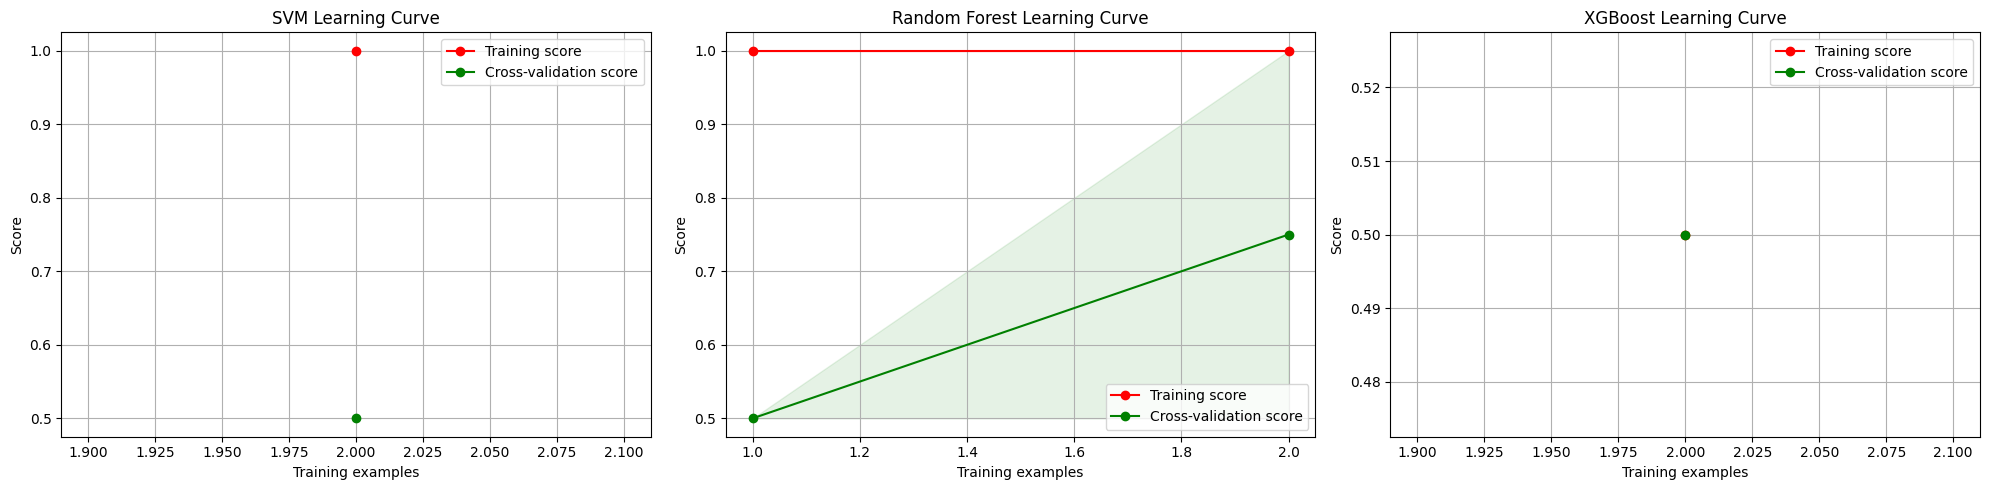

In [15]:
import os
os.environ["WANDB_DISABLED"] = "true"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from torch.utils.data import Dataset

# Load sample of training data for demo
df = pd.read_csv('/kaggle/input/leash-BELKA/train.csv', nrows=1000)  # Increased sample size to 1000 rows

# Check the class distribution
print(df['binds'].value_counts())

# Ensure both classes are present in the dataset
df_positive = df[df['binds'] == 1]
df_negative = df[df['binds'] == 0]

# Balance the dataset
min_class_samples = min(len(df_positive), len(df_negative))
df = pd.concat([df_positive.sample(min_class_samples), df_negative.sample(min_class_samples)])
df = df.sample(frac=1).reset_index(drop=True)

smiles = df['molecule_smiles']
labels = df['binds']

# Load pre-trained MolFormer model checkpoint and tokenizer
mf_tokenizer = AutoTokenizer.from_pretrained('ibm/MoLFormer-XL-both-10pct', deterministic_eval=True, trust_remote_code=True)
mf_model = AutoModelForSequenceClassification.from_pretrained('ibm/MoLFormer-XL-both-10pct', num_labels=2, trust_remote_code=True)

# Tokenize SMILES
class MoleculeDataset(Dataset):
    def __init__(self, smiles, labels, tokenizer):
        self.smiles = smiles
        self.labels = labels
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.smiles)
    
    def __getitem__(self, idx):
        encoded_input = self.tokenizer(self.smiles[idx], padding="max_length", truncation=True, max_length=128, return_tensors="pt")
        encoded_input = {key: val.squeeze(0) for key, val in encoded_input.items()}
        encoded_input['labels'] = torch.tensor(self.labels[idx])
        return encoded_input

# Train-test split
train_idx, val_idx = train_test_split(np.arange(len(df)), test_size=0.2, stratify=labels)
train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]

train_dataset = MoleculeDataset(train_df['molecule_smiles'].tolist(), train_df['binds'].tolist(), mf_tokenizer)
val_dataset = MoleculeDataset(val_df['molecule_smiles'].tolist(), val_df['binds'].tolist(), mf_tokenizer)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          
    evaluation_strategy="epoch",     
    learning_rate=2e-5,              
    per_device_train_batch_size=4,  # Reduced batch size for quicker training
    per_device_eval_batch_size=4,   # Reduced batch size for quicker evaluation
    num_train_epochs=1,              # Reduced to 1 epoch for quicker training
    weight_decay=0.01,               
    logging_dir='./logs',            
    report_to="none",                
)

# Define metric function
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(labels, pred)
    f1 = f1_score(labels, pred, average='macro')
    try:
        roc_auc = roc_auc_score(labels, pred)
    except ValueError:
        roc_auc = 0.5  # Default ROC AUC score if only one class is present
    return {"accuracy": accuracy, "f1": f1, "roc_auc": roc_auc}

# Define trainer
trainer = Trainer(
    model=mf_model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=val_dataset,            
    compute_metrics=compute_metrics,     
)

# Train and evaluate the model
trainer.train()
trainer.evaluate()

# Extract features and labels
train_features = np.array([mf_model(**mf_tokenizer(sm, return_tensors="pt").to(mf_model.device)).logits.cpu().detach().numpy() for sm in train_df['molecule_smiles']])
val_features = np.array([mf_model(**mf_tokenizer(sm, return_tensors="pt").to(mf_model.device)).logits.cpu().detach().numpy() for sm in val_df['molecule_smiles']])

train_features = np.squeeze(train_features)
val_features = np.squeeze(val_features)

train_labels = train_df['binds'].values
val_labels = val_df['binds'].values

# Evaluate models
def evaluate_model(model, features, labels):
    predictions = model.predict(features)
    prob_predictions = model.predict_proba(features)[:, 1]
    roc_auc = roc_auc_score(labels, prob_predictions)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    return roc_auc, accuracy, f1

# Use trained MolFormer for inference
svm_model = SVC(probability=True)
rf_model = RandomForestClassifier()
xgb_model = XGBClassifier()

svm_model.fit(train_features, train_labels)
rf_model.fit(train_features, train_labels)
xgb_model.fit(train_features, train_labels)

svm_metrics = evaluate_model(svm_model, val_features, val_labels)
rf_metrics = evaluate_model(rf_model, val_features, val_labels)
xgb_metrics = evaluate_model(xgb_model, val_features, val_labels)

print(f"SVM Metrics: ROC AUC: {svm_metrics[0]}, Accuracy: {svm_metrics[1]}, F1 Score: {svm_metrics[2]}")
print(f"Random Forest Metrics: ROC AUC: {rf_metrics[0]}, Accuracy: {rf_metrics[1]}, F1 Score: {rf_metrics[2]}")
print(f"XGBoost Metrics: ROC AUC: {xgb_metrics[0]}, Accuracy: {xgb_metrics[1]}, F1 Score: {xgb_metrics[2]}")

# Ensemble model
ensemble_model = VotingClassifier(estimators=[
    ('svm', svm_model), ('rf', rf_model), ('xgb', xgb_model)
], voting='soft')

ensemble_model.fit(train_features, train_labels)
ensemble_metrics = evaluate_model(ensemble_model, val_features, val_labels)

print(f"Ensemble Metrics: ROC AUC: {ensemble_metrics[0]}, Accuracy: {ensemble_metrics[1]}, F1 Score: {ensemble_metrics[2]}")

# Learning curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), ax=None):
    if ax is None:
        ax = plt.gca()
    
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax.grid()

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
            label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
            label="Cross-validation score")

    ax.legend(loc="best")
    return ax

cv = StratifiedKFold(n_splits=2)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

plot_learning_curve(svm_model, "SVM Learning Curve", train_features, train_labels, cv=cv, ax=axes[0])
plot_learning_curve(rf_model, "Random Forest Learning Curve", train_features, train_labels, cv=cv, ax=axes[1])
plot_learning_curve(xgb_model, "XGBoost Learning Curve", train_features, train_labels, cv=cv, ax=axes[2])

plt.tight_layout()
plt.show()


### MolFormer with all balanced classes building blocks, molecule smiles, and 1 hot encoded protein target name

1. Load and balance the dataset using DuckDB.
2. Concatenate all SMILES strings and one-hot encoded protein names.
3. Use MolFormer embeddings for traditional ML models both before and after training MolFormer.
4. Train and evaluate SVM, Random Forest, and XGBoost models to evaluate before and after trained MolFormer.
5. Train and evaluate ensemble models to evaluate before and after trained MolFormer.
6. Plot learning curves for the models.

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Some weights of MolformerForSequenceClassification were not initialized from the model checkpoint at ibm/MoLFormer-XL-both-10pct and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.dense2.bias', 'classifier.dense2.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Roc Auc
1,No log,0.676759,0.580000,0.571603,0.580000


SVM Metrics Before: ROC AUC: 0.5580999999999999, Accuracy: 0.535, F1 Score: 0.5185213947347985
Random Forest Metrics Before: ROC AUC: 0.49135, Accuracy: 0.495, F1 Score: 0.4913248218377779
XGBoost Metrics Before: ROC AUC: 0.4843, Accuracy: 0.515, F1 Score: 0.5122564424890006
SVM Metrics After: ROC AUC: 0.5838, Accuracy: 0.535, F1 Score: 0.5316159250585479
Random Forest Metrics After: ROC AUC: 0.5678, Accuracy: 0.535, F1 Score: 0.5335891070488227
XGBoost Metrics After: ROC AUC: 0.5971500000000001, Accuracy: 0.56, F1 Score: 0.56
Ensemble Metrics Before: ROC AUC: 0.49050000000000005, Accuracy: 0.52, F1 Score: 0.5169082125603865
Ensemble Metrics After: ROC AUC: 0.5838, Accuracy: 0.545, F1 Score: 0.5447154471544715


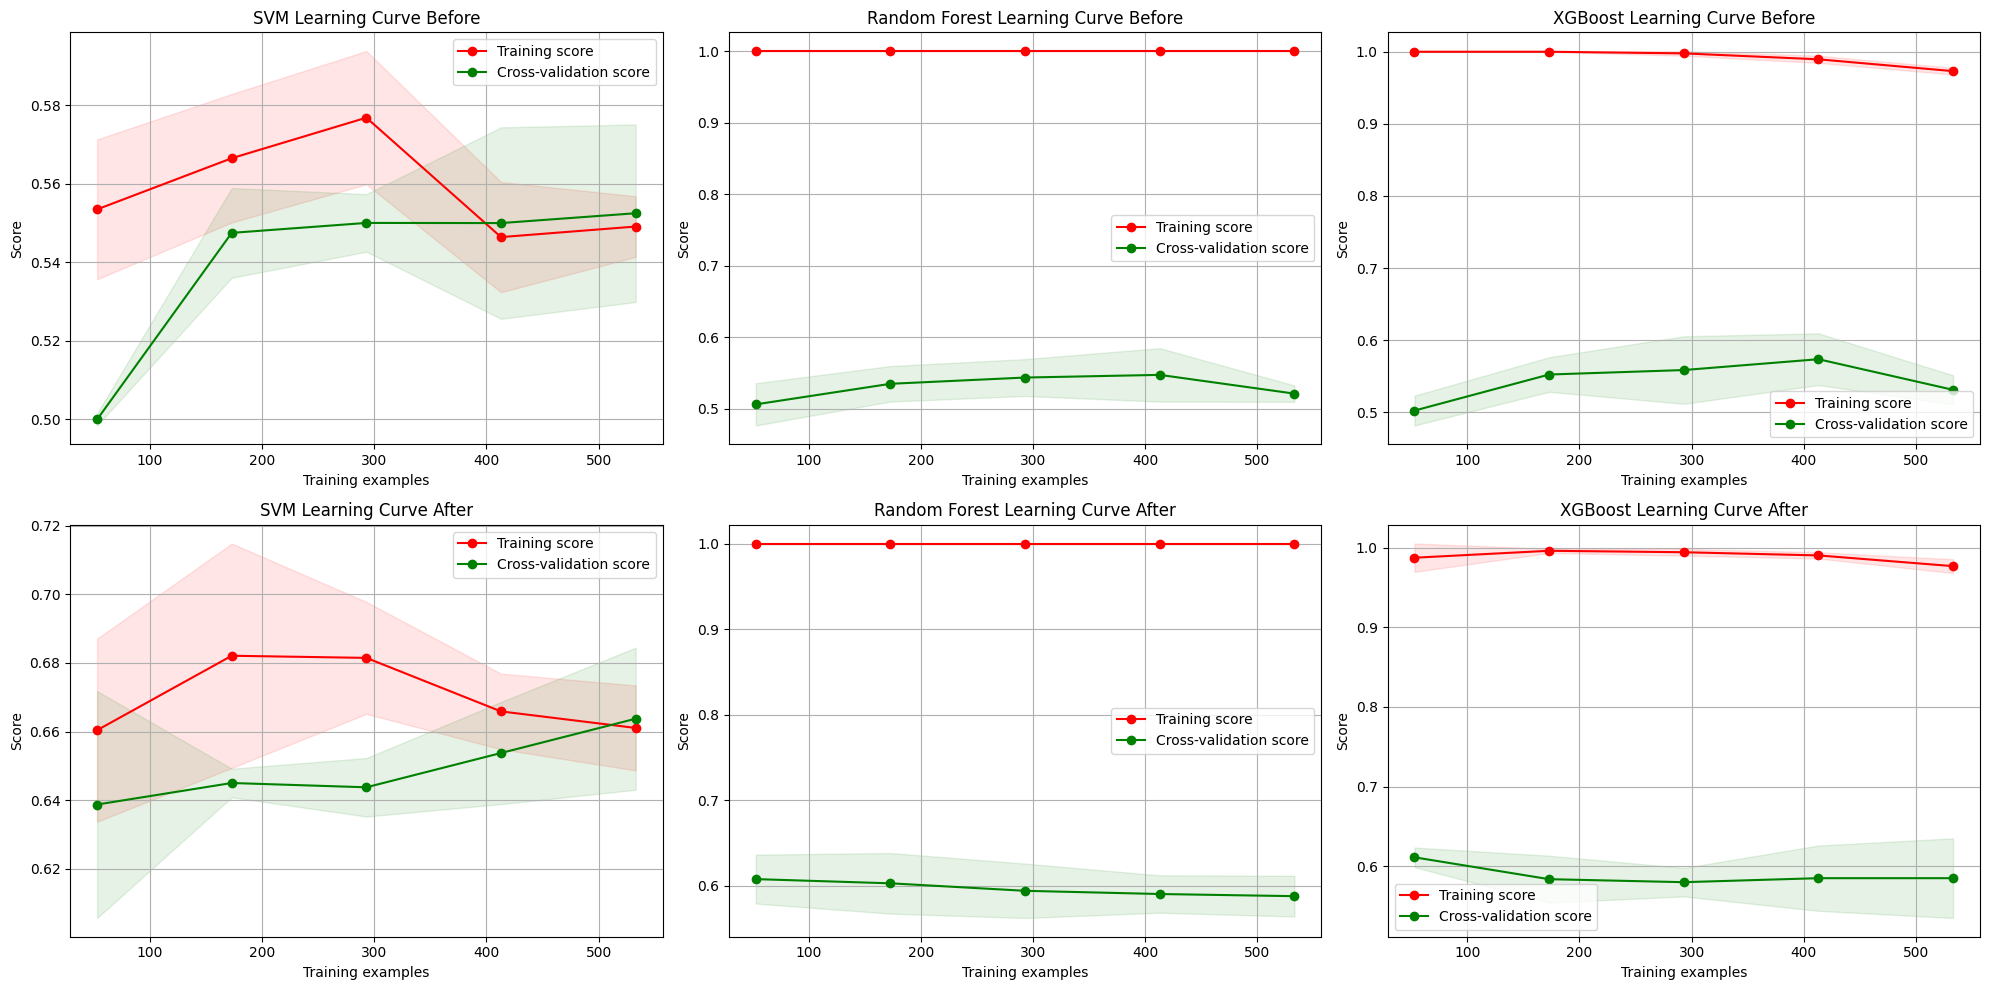

In [19]:
import os
os.environ["WANDB_DISABLED"] = "true"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import OneHotEncoder
import duckdb

# Load and balance dataset
train_path = '/kaggle/input/leash-BELKA/train.parquet'

con = duckdb.connect()

# Balance classes
df = con.query(f"""
    (SELECT *
     FROM parquet_scan('{train_path}')
     WHERE binds = 0
     ORDER BY random()
     LIMIT 500)
    UNION ALL
    (SELECT *
     FROM parquet_scan('{train_path}')
     WHERE binds = 1
     ORDER BY random()
     LIMIT 500)
""").df()

con.close()

# Concatenate all SMILES strings
df['combined_smiles'] = df['molecule_smiles'] + ' ' + df['buildingblock1_smiles'] + ' ' + df['buildingblock2_smiles'] + ' ' + df['buildingblock3_smiles']

# One-hot encode protein names
encoder = OneHotEncoder()
protein_one_hot = encoder.fit_transform(df[['protein_name']]).toarray()

# Convert one-hot encoded proteins to string and concatenate with SMILES
protein_str = [' '.join(map(str, row)) for row in protein_one_hot]
df['enhanced_smiles'] = df['combined_smiles'] + ' ' + protein_str

# Split data
smiles = df['enhanced_smiles']
labels = df['binds']
train_idx, val_idx = train_test_split(np.arange(len(df)), test_size=0.2, stratify=labels)
train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]

# Tokenize SMILES
class MoleculeDataset(Dataset):
    def __init__(self, smiles, labels, tokenizer):
        self.smiles = smiles
        self.labels = labels
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.smiles)
    
    def __getitem__(self, idx):
        encoded_input = self.tokenizer(self.smiles[idx], padding="max_length", truncation=True, max_length=512, return_tensors="pt")
        encoded_input = {key: val.squeeze(0) for key, val in encoded_input.items()}
        encoded_input['labels'] = torch.tensor(self.labels[idx])
        return encoded_input

# Load pre-trained MolFormer model checkpoint and tokenizer
mf_tokenizer = AutoTokenizer.from_pretrained('ibm/MoLFormer-XL-both-10pct', deterministic_eval=True, trust_remote_code=True)
mf_model = AutoModelForSequenceClassification.from_pretrained('ibm/MoLFormer-XL-both-10pct', num_labels=2, trust_remote_code=True)

train_dataset = MoleculeDataset(train_df['enhanced_smiles'].tolist(), train_df['binds'].tolist(), mf_tokenizer)
val_dataset = MoleculeDataset(val_df['enhanced_smiles'].tolist(), val_df['binds'].tolist(), mf_tokenizer)

# Extract features before training MolFormer
def extract_features(smiles_list, tokenizer, model):
    model.eval()
    features = []
    with torch.no_grad():
        for sm in smiles_list:
            encoded_input = tokenizer(sm, return_tensors="pt", truncation=True, max_length=512).to(model.device)
            logits = model(**encoded_input).logits.cpu().detach().numpy()
            features.append(logits)
    return np.squeeze(features)

train_features_before = extract_features(train_df['enhanced_smiles'].tolist(), mf_tokenizer, mf_model)
val_features_before = extract_features(val_df['enhanced_smiles'].tolist(), mf_tokenizer, mf_model)

# Train MolFormer for a minimal number of epochs
training_args = TrainingArguments(
    output_dir='./results',          
    evaluation_strategy="epoch",     
    learning_rate=2e-5,              
    per_device_train_batch_size=8,   
    per_device_eval_batch_size=8,    
    num_train_epochs=1,              
    weight_decay=0.01,               
    logging_dir='./logs',            
    report_to="none",                # Disable W&B logging
)

# Define metric function
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(labels, pred)
    f1 = f1_score(labels, pred, average='macro')
    roc_auc = roc_auc_score(labels, pred)
    return {"accuracy": accuracy, "f1": f1, "roc_auc": roc_auc}

# Define trainer
trainer = Trainer(
    model=mf_model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=val_dataset,            
    compute_metrics=compute_metrics,     
)

# Train and evaluate the model
trainer.train()
trainer.evaluate()

# Extract features after training MolFormer
train_features_after = extract_features(train_df['enhanced_smiles'].tolist(), mf_tokenizer, mf_model)
val_features_after = extract_features(val_df['enhanced_smiles'].tolist(), mf_tokenizer, mf_model)

train_labels = train_df['binds'].values
val_labels = val_df['binds'].values

# Evaluate models
def evaluate_model(model, features, labels):
    predictions = model.predict(features)
    prob_predictions = model.predict_proba(features)[:, 1]
    roc_auc = roc_auc_score(labels, prob_predictions)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    return roc_auc, accuracy, f1

# Train traditional ML models before MolFormer training
svm_model_before = SVC(probability=True)
rf_model_before = RandomForestClassifier()
xgb_model_before = XGBClassifier()

svm_model_before.fit(train_features_before, train_labels)
rf_model_before.fit(train_features_before, train_labels)
xgb_model_before.fit(train_features_before, train_labels)

svm_metrics_before = evaluate_model(svm_model_before, val_features_before, val_labels)
rf_metrics_before = evaluate_model(rf_model_before, val_features_before, val_labels)
xgb_metrics_before = evaluate_model(xgb_model_before, val_features_before, val_labels)

print(f"SVM Metrics Before: ROC AUC: {svm_metrics_before[0]}, Accuracy: {svm_metrics_before[1]}, F1 Score: {svm_metrics_before[2]}")
print(f"Random Forest Metrics Before: ROC AUC: {rf_metrics_before[0]}, Accuracy: {rf_metrics_before[1]}, F1 Score: {rf_metrics_before[2]}")
print(f"XGBoost Metrics Before: ROC AUC: {xgb_metrics_before[0]}, Accuracy: {xgb_metrics_before[1]}, F1 Score: {xgb_metrics_before[2]}")

# Train traditional ML models after MolFormer training
svm_model_after = SVC(probability=True)
rf_model_after = RandomForestClassifier()
xgb_model_after = XGBClassifier()

svm_model_after.fit(train_features_after, train_labels)
rf_model_after.fit(train_features_after, train_labels)
xgb_model_after.fit(train_features_after, train_labels)

svm_metrics_after = evaluate_model(svm_model_after, val_features_after, val_labels)
rf_metrics_after = evaluate_model(rf_model_after, val_features_after, val_labels)
xgb_metrics_after = evaluate_model(xgb_model_after, val_features_after, val_labels)

print(f"SVM Metrics After: ROC AUC: {svm_metrics_after[0]}, Accuracy: {svm_metrics_after[1]}, F1 Score: {svm_metrics_after[2]}")
print(f"Random Forest Metrics After: ROC AUC: {rf_metrics_after[0]}, Accuracy: {rf_metrics_after[1]}, F1 Score: {rf_metrics_after[2]}")
print(f"XGBoost Metrics After: ROC AUC: {xgb_metrics_after[0]}, Accuracy: {xgb_metrics_after[1]}, F1 Score: {xgb_metrics_after[2]}")

# Ensemble models before MolFormer training
ensemble_model_before = VotingClassifier(estimators=[
    ('svm', svm_model_before), ('rf', rf_model_before), ('xgb', xgb_model_before)
], voting='soft')

ensemble_model_before.fit(train_features_before, train_labels)
ensemble_metrics_before = evaluate_model(ensemble_model_before, val_features_before, val_labels)

print(f"Ensemble Metrics Before: ROC AUC: {ensemble_metrics_before[0]}, Accuracy: {ensemble_metrics_before[1]}, F1 Score: {ensemble_metrics_before[2]}")

# Ensemble models after MolFormer training
ensemble_model_after = VotingClassifier(estimators=[
    ('svm', svm_model_after), ('rf', rf_model_after), ('xgb', xgb_model_after)
], voting='soft')

ensemble_model_after.fit(train_features_after, train_labels)
ensemble_metrics_after = evaluate_model(ensemble_model_after, val_features_after, val_labels)

print(f"Ensemble Metrics After: ROC AUC: {ensemble_metrics_after[0]}, Accuracy: {ensemble_metrics_after[1]}, F1 Score: {ensemble_metrics_after[2]}")

# Learning curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), ax=None):
    if ax is None:
        ax = plt.gca()
    
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax.grid()

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
            label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
            label="Cross-validation score")

    ax.legend(loc="best")
    return ax

cv = StratifiedKFold(n_splits=3)

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

plot_learning_curve(svm_model_before, "SVM Learning Curve Before", train_features_before, train_labels, cv=cv, ax=axes[0, 0])
plot_learning_curve(rf_model_before, "Random Forest Learning Curve Before", train_features_before, train_labels, cv=cv, ax=axes[0, 1])
plot_learning_curve(xgb_model_before, "XGBoost Learning Curve Before", train_features_before, train_labels, cv=cv, ax=axes[0, 2])

plot_learning_curve(svm_model_after, "SVM Learning Curve After", train_features_after, train_labels, cv=cv, ax=axes[1, 0])
plot_learning_curve(rf_model_after, "Random Forest Learning Curve After", train_features_after, train_labels, cv=cv, ax=axes[1, 1])
plot_learning_curve(xgb_model_after, "XGBoost Learning Curve After", train_features_after, train_labels, cv=cv, ax=axes[1, 2])

plt.tight_layout()
plt.show()


### ECFP Fingerprints Optimization with Genetic Algorithm

1. Data Loading:
- Load the dataset using DuckDB and balance the classes by selecting 500 examples from each class.

2. Combine SMILES and Molecule Conversion:
- Combine the molecule SMILES with building block SMILES.
- Convert these combined SMILES into RDKit molecule objects.

3. One-Hot Encoding:
- One-hot encode the protein names.

4. Genetic Algorithm (GA):
- Define a GA to optimize the bit length and radius for ECFP generation.
- Evaluate each individual (combination of bit length and radius) by calculating the mean average precision score using both Random Forest and SVM classifiers.

5. Evaluation Function:
- Generate ECFPs with given parameters.
- Combine the ECFPs with one-hot encoded protein names.
- Train and evaluate Random Forest and SVM classifiers, returning the average precision score as the fitness value.

6. GA Execution:
- Run the GA to find the optimal parameters for ECFP generation.

In [20]:
import duckdb
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import OneHotEncoder
from deap import base, creator, tools, algorithms
import random

# Load and balance the dataset using DuckDB
train_path = '/kaggle/input/leash-BELKA/train.parquet'

con = duckdb.connect()

df = con.query(f"""
    (SELECT *
     FROM parquet_scan('{train_path}')
     WHERE binds = 0
     ORDER BY random()
     LIMIT 500)
    UNION ALL
    (SELECT *
     FROM parquet_scan('{train_path}')
     WHERE binds = 1
     ORDER BY random()
     LIMIT 500)
""").df()

con.close()

# Combine SMILES strings
df['combined_smiles'] = df['molecule_smiles'] + ' ' + df['buildingblock1_smiles'] + ' ' + df['buildingblock2_smiles'] + ' ' + df['buildingblock3_smiles']

# Convert SMILES to RDKit molecules
df['molecule'] = df['combined_smiles'].apply(Chem.MolFromSmiles)

# Generate ECFPs
def generate_ecfp(molecule, radius, bits):
    if molecule is None:
        return None
    return list(AllChem.GetMorganFingerprintAsBitVect(molecule, radius, nBits=bits))

# One-hot encode the protein_name
onehot_encoder = OneHotEncoder(sparse_output=False)
protein_onehot = onehot_encoder.fit_transform(df['protein_name'].values.reshape(-1, 1))

# Genetic Algorithm setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

def evaluate_ecfp(individual):
    radius, bits = individual
    df['ecfp'] = df['molecule'].apply(lambda mol: generate_ecfp(mol, radius, bits))
    X = [ecfp + protein for ecfp, protein in zip(df['ecfp'].tolist(), protein_onehot.tolist())]
    y = df['binds'].tolist()
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Random Forest Model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]
    map_score_rf = average_precision_score(y_test, y_pred_proba_rf)
    
    # SVM Model
    svm_model = SVC(probability=True, random_state=42)
    svm_model.fit(X_train, y_train)
    y_pred_proba_svm = svm_model.predict_proba(X_test)[:, 1]
    map_score_svm = average_precision_score(y_test, y_pred_proba_svm)
    
    return (map_score_rf + map_score_svm) / 2,

toolbox = base.Toolbox()
toolbox.register("attr_radius", random.randint, 3, 8)
toolbox.register("attr_bits", random.randint, 4, 12)
toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.attr_radius, toolbox.attr_bits), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_ecfp)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=[3, 4], up=[8, 12], indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

def main():
    random.seed(42)
    population = toolbox.population(n=20)
    algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, verbose=True)
    best_individual = tools.selBest(population, k=1)[0]
    print(f"Best individual: Radius = {best_individual[0]}, Bits = {best_individual[1]}")

if __name__ == "__main__":
    main()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

gen	nevals
0  	20    
1  	14    
2  	14    
3  	12    
4  	14    
5  	14    
6  	10    
7  	12    
8  	14    
9  	14    
10 	14    
Best individual: Radius = 3, Bits = 11


### Hybrid Embeddings with MolFormer and ECFP Fingerprints

1. ECFP Generation:
- Use the optimized parameters to generate ECFP fingerprints.

2. MolFormer Embeddings:
- Load the pre-trained MolFormer model and tokenizer.
- Tokenize the combined SMILES and get the MolFormer embeddings.

3. Hybrid Embeddings:
- Combine the ECFP fingerprints with the MolFormer embeddings to create the hybrid feature vector.

4. Prepare Data for Modeling:
- Extract the feature vectors (X) and labels (y) from the dataframe for subsequent modeling steps.

In [5]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from transformers import AutoTokenizer, AutoModel
import torch

# Load a smaller subset of data
import duckdb

train_path = '/kaggle/input/leash-BELKA/train.parquet'
con = duckdb.connect()

df = con.query(f"""
    (SELECT *
    FROM parquet_scan('{train_path}')
    WHERE binds = 0
    ORDER BY random()
    LIMIT 100)
    UNION ALL
    (SELECT *
    FROM parquet_scan('{train_path}')
    WHERE binds = 1
    ORDER BY random()
    LIMIT 100)
""").df()

con.close()

# Combine SMILES strings
df['combined_smiles'] = df['molecule_smiles'] + ' ' + df['buildingblock1_smiles'] + ' ' + df['buildingblock2_smiles'] + ' ' + df['buildingblock3_smiles']

# One-hot encode the protein_name
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse_output=False)
protein_onehot = onehot_encoder.fit_transform(df[['protein_name']])

# Add one-hot encoded protein names to the dataframe
df['protein_onehot'] = list(protein_onehot)

# Convert SMILES to RDKit molecules
df['molecule'] = df['molecule_smiles'].apply(Chem.MolFromSmiles)

# Function to generate ECFP fingerprints
def generate_ecfp(molecule, radius=5, bits=10):
    if molecule is None:
        return None
    return list(AllChem.GetMorganFingerprintAsBitVect(molecule, radius, nBits=bits))

# Generate ECFPs
df['ecfp'] = df['molecule'].apply(generate_ecfp)

# Load pre-trained MolFormer model and tokenizer
mf_tokenizer = AutoTokenizer.from_pretrained('ibm/MoLFormer-XL-both-10pct', deterministic_eval=True, trust_remote_code=True)
mf_model = AutoModel.from_pretrained('ibm/MoLFormer-XL-both-10pct', trust_remote_code=True)
mf_model.eval()

# Tokenize SMILES and get embeddings
def get_molformer_embeddings(smiles):
    inputs = mf_tokenizer(smiles, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = mf_model(**inputs)
    return outputs.pooler_output

df['molformer_embeddings'] = df['combined_smiles'].apply(lambda x: get_molformer_embeddings(x).numpy())

# Combine ECFPs and MolFormer embeddings
def combine_features(ecfp, molformer, protein_onehot):
    return np.concatenate([ecfp, molformer, protein_onehot])

df['hybrid_embeddings'] = df.apply(lambda row: combine_features(row['ecfp'], row['molformer_embeddings'].flatten(), row['protein_onehot']), axis=1)

# Convert to list of feature vectors for modeling
X = df['hybrid_embeddings'].tolist()
y = df['binds'].tolist()

# Verify the shapes of X and y
print(f"X shape: {np.array(X).shape}")
print(f"y shape: {np.array(y).shape}")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

X shape: (200, 781)
y shape: (200,)


### Vector Search for feature selection

1. Convert the hybrid_embeddings to a numpy array.
2. Normalize the embeddings.
3. Initialize and add embeddings to the FAISS index.
4. Retrieve the top k nearest neighbors for each embedding.
5. Augment the embeddings with their nearest neighbors.
6. Create the final feature vector X_final and verify its shape along with y_final.

In [6]:
import faiss
import numpy as np

# Convert hybrid embeddings to numpy array and ensure float32 type
hybrid_embeddings = np.vstack(df['hybrid_embeddings'].values).astype(np.float32)

# Normalize embeddings
faiss.normalize_L2(hybrid_embeddings)

# Initialize FAISS index with CPU
d = hybrid_embeddings.shape[1]  # Dimension of the embeddings
index = faiss.IndexFlatL2(d)  # Index for flat (exact) L2 distance

# Add embeddings to the index
index.add(hybrid_embeddings)

# Retrieve the top k nearest neighbors for each embedding
k = 5  # Number of nearest neighbors to retrieve
D, I = index.search(hybrid_embeddings, k)

# Function to augment embeddings with neighbors
def augment_with_neighbors(embeddings, neighbors_idx):
    augmented_embeddings = []
    for i, neighbors in enumerate(neighbors_idx):
        neighbor_embeddings = embeddings[neighbors]
        augmented_embedding = np.mean(neighbor_embeddings, axis=0)
        augmented_embeddings.append(augmented_embedding)
    return np.array(augmented_embeddings)

# Augment hybrid embeddings with their nearest neighbors
augmented_embeddings = augment_with_neighbors(hybrid_embeddings, I)

# Verify the shape of the augmented embeddings
print(f"Original hybrid embeddings shape: {hybrid_embeddings.shape}")
print(f"Augmented embeddings shape: {augmented_embeddings.shape}")

# Final feature


Original hybrid embeddings shape: (200, 781)
Augmented embeddings shape: (200, 781)


### RAG augmentation on embeddings

1. Initialization and Similarity Scores:
- We initialize a small constant 𝜖 to avoid division by zero.
- Convert the distances to similarity scores by taking the inverse of each distance.

3. Attention Weights:
- We calculate the attention weights using the softmax function applied to the similarity scores.

3. Weighted Averaging:
- Compute the weighted average of the neighbor embeddings using the attention weights.
- Concatenate the original embedding with the weighted average to form the final embedding.

In [7]:
import torch.nn.functional as F

# Function to apply attention mechanism and weighted averaging
def apply_attention_and_weighted_averaging(embeddings, neighbors_idx, distances):
    augmented_embeddings = []
    for i, (neighbors, dist) in enumerate(zip(neighbors_idx, distances)):
        neighbor_embeddings = embeddings[neighbors]

        # Calculate attention weights
        # Convert distances to similarity scores (inverse of distance)
        similarities = 1 / (dist + 1e-6)
        attention_weights = F.softmax(torch.tensor(similarities), dim=0).numpy()

        # Weighted averaging of neighbor embeddings
        weighted_average = np.average(neighbor_embeddings, axis=0, weights=attention_weights)
        
        # Combine the original embedding with the weighted average of neighbors
        final_embedding = np.concatenate([embeddings[i], weighted_average])
        augmented_embeddings.append(final_embedding)
    
    return np.array(augmented_embeddings)

# Apply attention mechanism and weighted averaging to augment hybrid embeddings
final_feature_vectors = apply_attention_and_weighted_averaging(hybrid_embeddings, I, D)

# Verify the shape of the final feature vectors
print(f"Final feature vectors shape: {final_feature_vectors.shape}")

# Use these final feature vectors for model training and evaluation
X_final = final_feature_vectors
y = df['binds'].tolist()

# Verify the shapes of X_final and y
print(f"X_final shape: {np.array(X_final).shape}")
print(f"y shape: {np.array(y).shape}")

# Continue with model training and evaluation using the final feature vectors


Final feature vectors shape: (200, 1562)
X_final shape: (200, 1562)
y shape: (200,)


### Vector Search and RAG Ensemble Model

1. Split the dataset into training and testing sets.
2. Train individual models (SVM, Random Forest, and XGBoost) on the training set.
3. Evaluate each model on the test set using metrics such as ROC AUC, accuracy, and F1 score.
4. Combine the individual models into an ensemble using soft voting.
5. Train the ensemble model and evaluate its performance.
6. Finally, we plot the learning curves for each of the individual models to visualize their training and validation performance over different training set sizes.

X_final shape: (200, 1562)
y shape: (200,)
SVM Metrics: ROC AUC: 0.36749999999999994, Accuracy: 0.45, F1 Score: 0.4486215538847118
Random Forest Metrics: ROC AUC: 0.29, Accuracy: 0.375, F1 Score: 0.37460913070669166
XGBoost Metrics: ROC AUC: 0.35, Accuracy: 0.4, F1 Score: 0.3939393939393939
Ensemble Metrics: ROC AUC: 0.35750000000000004, Accuracy: 0.4, F1 Score: 0.3939393939393939


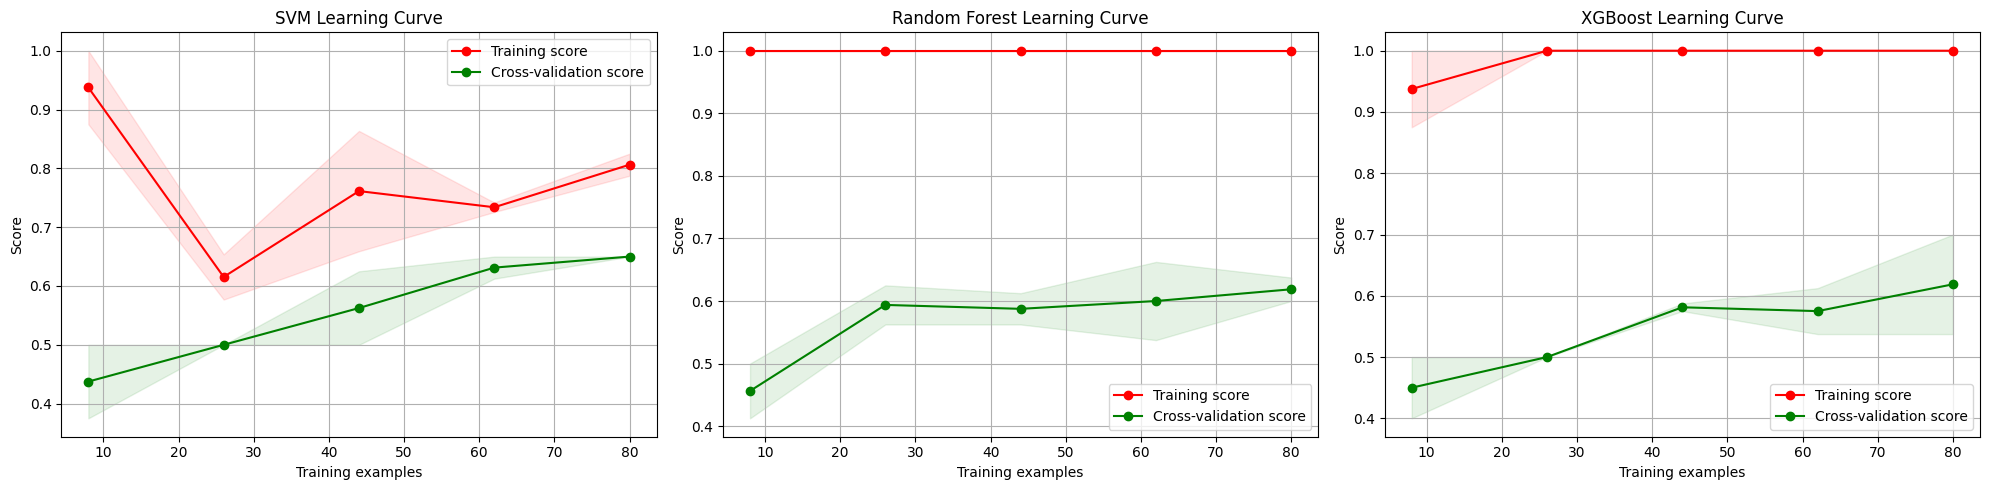

In [8]:
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Use these final feature vectors for model training and evaluation
X_final = final_feature_vectors
y = df['binds'].tolist()

# Verify the shapes of X_final and y
print(f"X_final shape: {np.array(X_final).shape}")
print(f"y shape: {np.array(y).shape}")

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

# Train individual models
svm_model = SVC(probability=True, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the models
svm_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Evaluate models
def evaluate_model(model, features, labels):
    predictions = model.predict(features)
    prob_predictions = model.predict_proba(features)[:, 1]
    roc_auc = roc_auc_score(labels, prob_predictions)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    return roc_auc, accuracy, f1

svm_metrics = evaluate_model(svm_model, X_test, y_test)
rf_metrics = evaluate_model(rf_model, X_test, y_test)
xgb_metrics = evaluate_model(xgb_model, X_test, y_test)

print(f"SVM Metrics: ROC AUC: {svm_metrics[0]}, Accuracy: {svm_metrics[1]}, F1 Score: {svm_metrics[2]}")
print(f"Random Forest Metrics: ROC AUC: {rf_metrics[0]}, Accuracy: {rf_metrics[1]}, F1 Score: {rf_metrics[2]}")
print(f"XGBoost Metrics: ROC AUC: {xgb_metrics[0]}, Accuracy: {xgb_metrics[1]}, F1 Score: {xgb_metrics[2]}")

# Ensemble model
ensemble_model = VotingClassifier(estimators=[
    ('svm', svm_model), ('rf', rf_model), ('xgb', xgb_model)
], voting='soft')

ensemble_model.fit(X_train, y_train)
ensemble_metrics = evaluate_model(ensemble_model, X_test, y_test)

print(f"Ensemble Metrics: ROC AUC: {ensemble_metrics[0]}, Accuracy: {ensemble_metrics[1]}, F1 Score: {ensemble_metrics[2]}")

# Learning curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), ax=None):
    if ax is None:
        ax = plt.gca()
    
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax.grid()

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
            label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
            label="Cross-validation score")

    ax.legend(loc="best")
    return ax

cv = StratifiedKFold(n_splits=2)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

plot_learning_curve(svm_model, "SVM Learning Curve", X_train, y_train, cv=cv, ax=axes[0])
plot_learning_curve(rf_model, "Random Forest Learning Curve", X_train, y_train, cv=cv, ax=axes[1])
plot_learning_curve(xgb_model, "XGBoost Learning Curve", X_train, y_train, cv=cv, ax=axes[2])

plt.tight_layout()
plt.show()


### Final Combined Ensemble Model

1. Training the First Ensemble Model: Using Vector Search and RAG final feature vector.
2. Training the Second Ensemble Model: Using the trained MolFormer embeddings.
3. Combining Predictions: The prediction probabilities from the two previous ensemble models are concatenated to form the final feature vectors.
4. Training Final Ensemble Model: A final ensemble model is trained using these combined prediction probabilities.
5. Evaluating Final Ensemble Model: The performance of the final combined ensemble model is evaluated on the validation set.
6. Plotting Learning Curve: A learning curve for the final combined ensemble model is plotted to visualize its performance over different training set sizes.

2024-07-06 20:05:05.602141: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-06 20:05:05.602231: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-06 20:05:05.611697: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Some weights of MolformerForSequenceClassification were not initialized from the model checkpoint at ibm/MoLFormer-XL-both-10pct and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.dense2.bias', 'classifier.dense2.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Roc Auc
1,No log,0.769822,0.500000,0.333333,0.500000


SVM Metrics Before: ROC AUC: 0.60375, Accuracy: 0.525, F1 Score: 0.4996708360763661
Random Forest Metrics Before: ROC AUC: 0.62375, Accuracy: 0.55, F1 Score: 0.5488721804511277
XGBoost Metrics Before: ROC AUC: 0.5974999999999999, Accuracy: 0.6, F1 Score: 0.5989974937343359
SVM Metrics After: ROC AUC: 0.6225, Accuracy: 0.5, F1 Score: 0.47916666666666663
Random Forest Metrics After: ROC AUC: 0.635, Accuracy: 0.6, F1 Score: 0.595959595959596
XGBoost Metrics After: ROC AUC: 0.6399999999999999, Accuracy: 0.65, F1 Score: 0.6464646464646464
Ensemble Metrics Before: ROC AUC: 0.6174999999999999, Accuracy: 0.575, F1 Score: 0.5747342088805503
Ensemble Metrics After: ROC AUC: 0.64, Accuracy: 0.6, F1 Score: 0.595959595959596


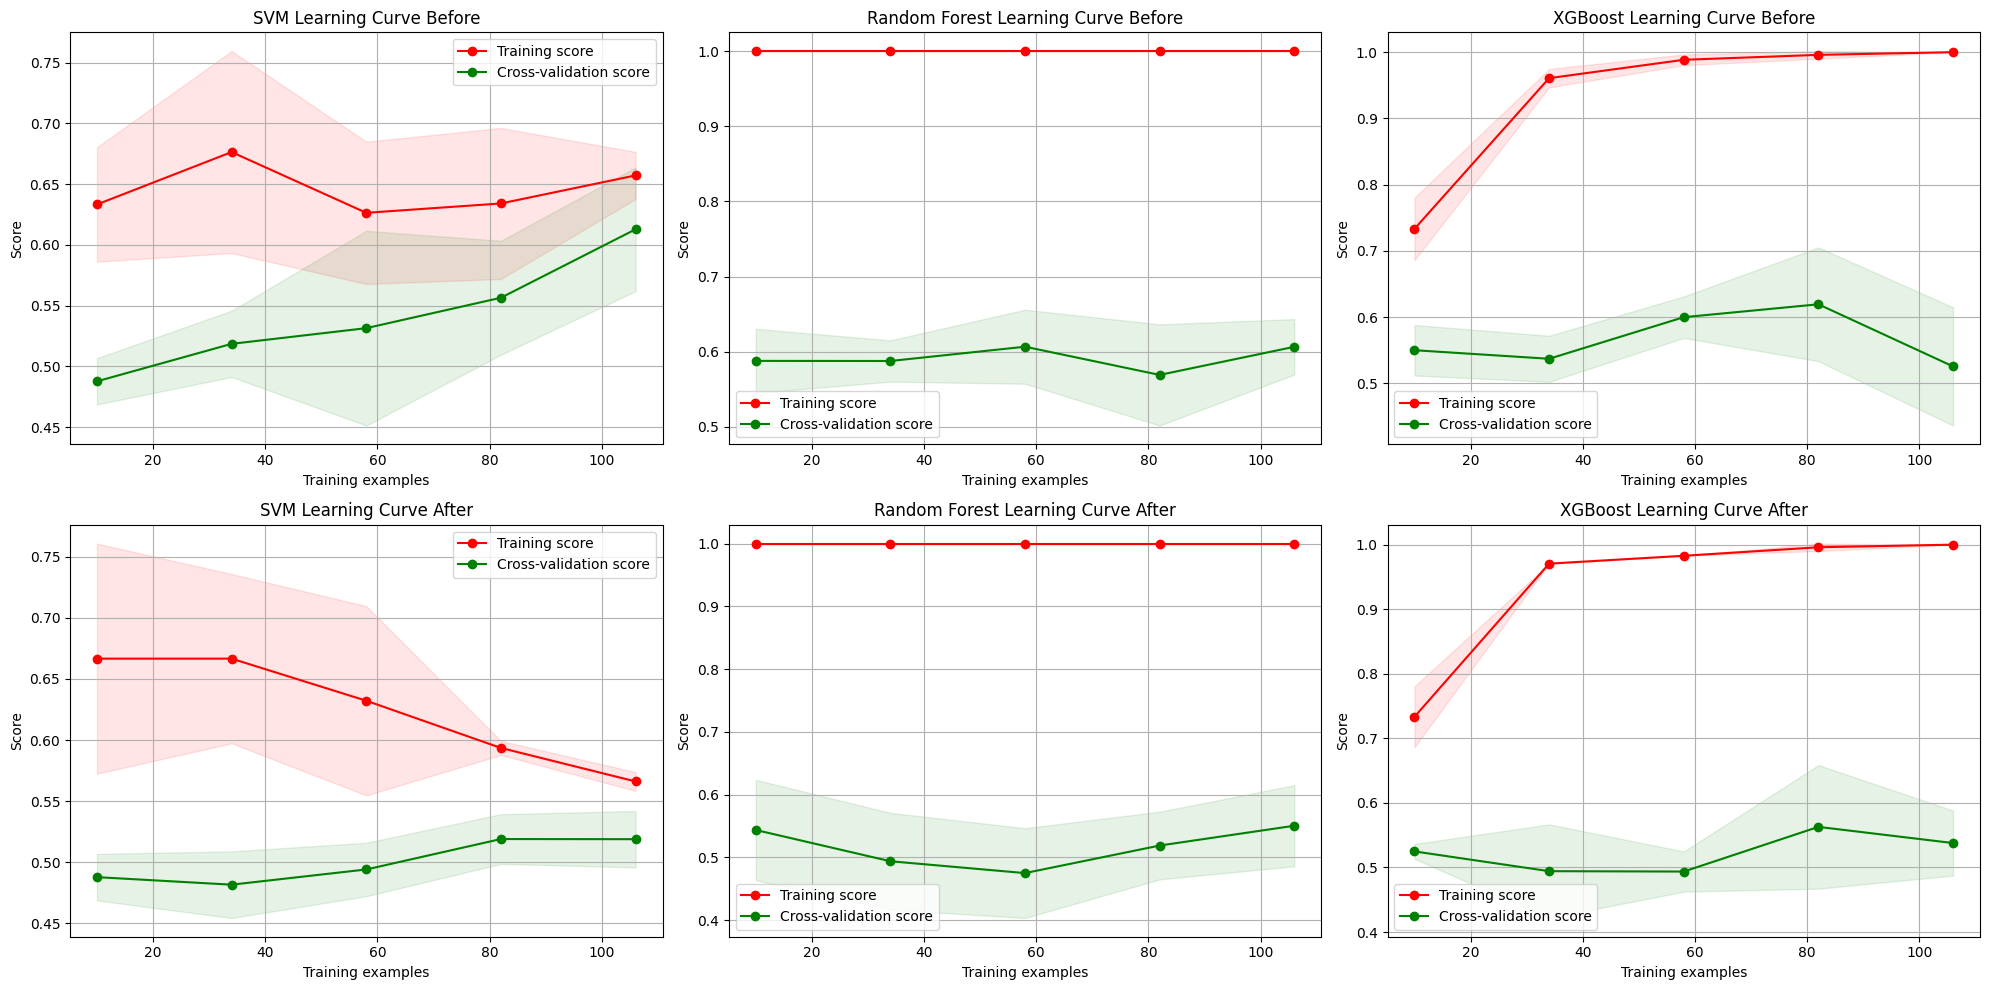

Final Combined Ensemble Metrics: ROC AUC: 0.3375, Accuracy: 0.375, F1 Score: 0.3650793650793651


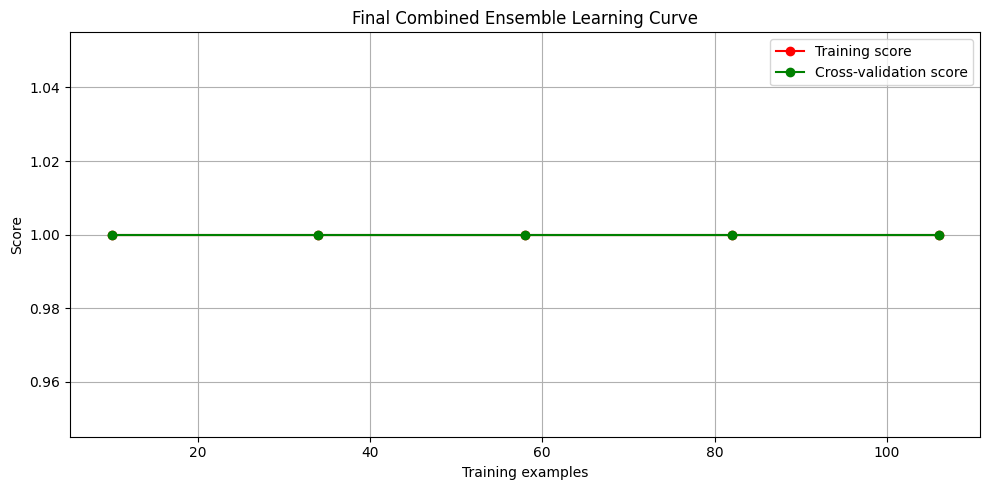

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import OneHotEncoder
import duckdb

# Load and balance dataset
train_path = '/kaggle/input/leash-BELKA/train.parquet'

con = duckdb.connect()

# Balance classes
df = con.query(f"""
    (SELECT *
     FROM parquet_scan('{train_path}')
     WHERE binds = 0
     ORDER BY random()
     LIMIT 100)
    UNION ALL
    (SELECT *
     FROM parquet_scan('{train_path}')
     WHERE binds = 1
     ORDER BY random()
     LIMIT 100)
""").df()

con.close()

# Concatenate all SMILES strings
df['combined_smiles'] = df['molecule_smiles'] + ' ' + df['buildingblock1_smiles'] + ' ' + df['buildingblock2_smiles'] + ' ' + df['buildingblock3_smiles']

# One-hot encode protein names
encoder = OneHotEncoder()
protein_one_hot = encoder.fit_transform(df[['protein_name']]).toarray()

# Convert one-hot encoded proteins to string and concatenate with SMILES
protein_str = [' '.join(map(str, row)) for row in protein_one_hot]
df['enhanced_smiles'] = df['combined_smiles'] + ' ' + protein_str

# Split data
smiles = df['enhanced_smiles']
labels = df['binds']
train_idx, val_idx = train_test_split(np.arange(len(df)), test_size=0.2, stratify=labels)
train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]

# Tokenize SMILES
class MoleculeDataset(Dataset):
    def __init__(self, smiles, labels, tokenizer):
        self.smiles = smiles
        self.labels = labels
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.smiles)
    
    def __getitem__(self, idx):
        encoded_input = self.tokenizer(self.smiles[idx], padding="max_length", truncation=True, max_length=512, return_tensors="pt")
        encoded_input = {key: val.squeeze(0) for key, val in encoded_input.items()}
        encoded_input['labels'] = torch.tensor(self.labels[idx])
        return encoded_input

# Load pre-trained MolFormer model checkpoint and tokenizer
mf_tokenizer = AutoTokenizer.from_pretrained('ibm/MoLFormer-XL-both-10pct', deterministic_eval=True, trust_remote_code=True)
mf_model = AutoModelForSequenceClassification.from_pretrained('ibm/MoLFormer-XL-both-10pct', num_labels=2, trust_remote_code=True)

train_dataset = MoleculeDataset(train_df['enhanced_smiles'].tolist(), train_df['binds'].tolist(), mf_tokenizer)
val_dataset = MoleculeDataset(val_df['enhanced_smiles'].tolist(), val_df['binds'].tolist(), mf_tokenizer)

# Extract features before training MolFormer
def extract_features(smiles_list, tokenizer, model):
    model.eval()
    features = []
    with torch.no_grad():
        for sm in smiles_list:
            encoded_input = tokenizer(sm, return_tensors="pt", truncation=True, max_length=512).to(model.device)
            logits = model(**encoded_input).logits.cpu().detach().numpy()
            features.append(logits)
    return np.squeeze(features)

train_features_before = extract_features(train_df['enhanced_smiles'].tolist(), mf_tokenizer, mf_model)
val_features_before = extract_features(val_df['enhanced_smiles'].tolist(), mf_tokenizer, mf_model)

# Train MolFormer for a minimal number of epochs
training_args = TrainingArguments(
    output_dir='./results',          
    evaluation_strategy="epoch",     
    learning_rate=2e-5,              
    per_device_train_batch_size=8,   
    per_device_eval_batch_size=8,    
    num_train_epochs=1,              
    weight_decay=0.01,               
    logging_dir='./logs',            
    report_to="none",                # Disable W&B logging
)

# Define metric function
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(labels, pred)
    f1 = f1_score(labels, pred, average='macro')
    roc_auc = roc_auc_score(labels, pred)
    return {"accuracy": accuracy, "f1": f1, "roc_auc": roc_auc}

# Define trainer
trainer = Trainer(
    model=mf_model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=val_dataset,            
    compute_metrics=compute_metrics,     
)

# Train and evaluate the model
trainer.train()
trainer.evaluate()

# Extract features after training MolFormer
train_features_after = extract_features(train_df['enhanced_smiles'].tolist(), mf_tokenizer, mf_model)
val_features_after = extract_features(val_df['enhanced_smiles'].tolist(), mf_tokenizer, mf_model)

train_labels = train_df['binds'].values
val_labels = val_df['binds'].values

# Evaluate models
def evaluate_model(model, features, labels):
    predictions = model.predict(features)
    prob_predictions = model.predict_proba(features)[:, 1]
    roc_auc = roc_auc_score(labels, prob_predictions)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    return roc_auc, accuracy, f1

# Train traditional ML models before MolFormer training
svm_model_before = SVC(probability=True)
rf_model_before = RandomForestClassifier()
xgb_model_before = XGBClassifier()

svm_model_before.fit(train_features_before, train_labels)
rf_model_before.fit(train_features_before, train_labels)
xgb_model_before.fit(train_features_before, train_labels)

svm_metrics_before = evaluate_model(svm_model_before, val_features_before, val_labels)
rf_metrics_before = evaluate_model(rf_model_before, val_features_before, val_labels)
xgb_metrics_before = evaluate_model(xgb_model_before, val_features_before, val_labels)

print(f"SVM Metrics Before: ROC AUC: {svm_metrics_before[0]}, Accuracy: {svm_metrics_before[1]}, F1 Score: {svm_metrics_before[2]}")
print(f"Random Forest Metrics Before: ROC AUC: {rf_metrics_before[0]}, Accuracy: {rf_metrics_before[1]}, F1 Score: {rf_metrics_before[2]}")
print(f"XGBoost Metrics Before: ROC AUC: {xgb_metrics_before[0]}, Accuracy: {xgb_metrics_before[1]}, F1 Score: {xgb_metrics_before[2]}")

# Train traditional ML models after MolFormer training
svm_model_after = SVC(probability=True)
rf_model_after = RandomForestClassifier()
xgb_model_after = XGBClassifier()

svm_model_after.fit(train_features_after, train_labels)
rf_model_after.fit(train_features_after, train_labels)
xgb_model_after.fit(train_features_after, train_labels)

svm_metrics_after = evaluate_model(svm_model_after, val_features_after, val_labels)
rf_metrics_after = evaluate_model(rf_model_after, val_features_after, val_labels)
xgb_metrics_after = evaluate_model(xgb_model_after, val_features_after, val_labels)

print(f"SVM Metrics After: ROC AUC: {svm_metrics_after[0]}, Accuracy: {svm_metrics_after[1]}, F1 Score: {svm_metrics_after[2]}")
print(f"Random Forest Metrics After: ROC AUC: {rf_metrics_after[0]}, Accuracy: {rf_metrics_after[1]}, F1 Score: {rf_metrics_after[2]}")
print(f"XGBoost Metrics After: ROC AUC: {xgb_metrics_after[0]}, Accuracy: {xgb_metrics_after[1]}, F1 Score: {xgb_metrics_after[2]}")

# Ensemble models before MolFormer training
ensemble_model_before = VotingClassifier(estimators=[
    ('svm', svm_model_before), ('rf', rf_model_before), ('xgb', xgb_model_before)
], voting='soft')

ensemble_model_before.fit(train_features_before, train_labels)
ensemble_metrics_before = evaluate_model(ensemble_model_before, val_features_before, val_labels)

print(f"Ensemble Metrics Before: ROC AUC: {ensemble_metrics_before[0]}, Accuracy: {ensemble_metrics_before[1]}, F1 Score: {ensemble_metrics_before[2]}")

# Ensemble models after MolFormer training
ensemble_model_after = VotingClassifier(estimators=[
    ('svm', svm_model_after), ('rf', rf_model_after), ('xgb', xgb_model_after)
], voting='soft')

ensemble_model_after.fit(train_features_after, train_labels)
ensemble_metrics_after = evaluate_model(ensemble_model_after, val_features_after, val_labels)

print(f"Ensemble Metrics After: ROC AUC: {ensemble_metrics_after[0]}, Accuracy: {ensemble_metrics_after[1]}, F1 Score: {ensemble_metrics_after[2]}")

# Learning curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), ax=None):
    if ax is None:
        ax = plt.gca()
    
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax.grid()

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
            label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
            label="Cross-validation score")

    ax.legend(loc="best")
    return ax

cv = StratifiedKFold(n_splits=3)

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

plot_learning_curve(svm_model_before, "SVM Learning Curve Before", train_features_before, train_labels, cv=cv, ax=axes[0, 0])
plot_learning_curve(rf_model_before, "Random Forest Learning Curve Before", train_features_before, train_labels, cv=cv, ax=axes[0, 1])
plot_learning_curve(xgb_model_before, "XGBoost Learning Curve Before", train_features_before, train_labels, cv=cv, ax=axes[0, 2])

plot_learning_curve(svm_model_after, "SVM Learning Curve After", train_features_after, train_labels, cv=cv, ax=axes[1, 0])
plot_learning_curve(rf_model_after, "Random Forest Learning Curve After", train_features_after, train_labels, cv=cv, ax=axes[1, 1])
plot_learning_curve(xgb_model_after, "XGBoost Learning Curve After", train_features_after, train_labels, cv=cv, ax=axes[1, 2])

plt.tight_layout()
plt.show()

# Now, the final combined ensemble model

# Predictions from first ensemble model (using Vector Search and RAG final feature vector)
X_train_first_ensemble = ensemble_model.predict_proba(X_train)
X_val_first_ensemble = ensemble_model.predict_proba(X_test)

# Predictions from second ensemble model (using trained MolFormer embeddings)
X_train_second_ensemble = ensemble_model_after.predict_proba(train_features_after)
X_val_second_ensemble = ensemble_model_after.predict_proba(val_features_after)

# Combine predictions
X_train_combined = np.hstack((X_train_first_ensemble, X_train_second_ensemble))
X_val_combined = np.hstack((X_val_first_ensemble, X_val_second_ensemble))

# Train final ensemble model on combined predictions
final_ensemble_model = VotingClassifier(estimators=[
    ('svm', SVC(probability=True)),
    ('rf', RandomForestClassifier()),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
], voting='soft')

final_ensemble_model.fit(X_train_combined, y_train)

# Evaluate final ensemble model
def evaluate_combined_model(model, features, labels):
    predictions = model.predict(features)
    prob_predictions = model.predict_proba(features)[:, 1]
    roc_auc = roc_auc_score(labels, prob_predictions)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    return roc_auc, accuracy, f1

final_ensemble_metrics = evaluate_combined_model(final_ensemble_model, X_val_combined, y_test)

print(f"Final Combined Ensemble Metrics: ROC AUC: {final_ensemble_metrics[0]}, Accuracy: {final_ensemble_metrics[1]}, F1 Score: {final_ensemble_metrics[2]}")

# Plot learning curves for the final combined ensemble model
def plot_learning_curve_combined(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), ax=None):
    if ax is None:
        ax = plt.gca()
    
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax.grid()

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
            label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
            label="Cross-validation score")

    ax.legend(loc="best")
    return ax

cv = StratifiedKFold(n_splits=3)

fig, ax = plt.subplots(figsize=(10, 5))
plot_learning_curve_combined(final_ensemble_model, "Final Combined Ensemble Learning Curve", X_train_combined, y_train, cv=cv, ax=ax)

plt.tight_layout()
plt.show()
